In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import random
from cv2 import resize
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [5]:
from google.colab import files
uploaded = files.upload()


Saving fault solar.zip to fault solar.zip


In [76]:
import zipfile

zip_path = 'fault solar.zip'  # New file name

if zipfile.is_zipfile(zip_path):
    print("✅ This is a valid zip file.")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('solar_dataset')
        print("✅ Extracted successfully.")
else:
    print("❌ This is NOT a valid zip file.")


✅ This is a valid zip file.
✅ Extracted successfully.


In [140]:
data_dir = "/content/solar_dataset/Faulty_solar_panel-20250424T064433Z-001/Faulty_solar_panel"


In [157]:
img_height = 244
img_width = 244

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32
)


Found 925 files belonging to 6 classes.
Using 740 files for training.
Found 925 files belonging to 6 classes.
Using 185 files for validation.


In [158]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [159]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [160]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False

In [161]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_27         │ (None, 244, 244)  │          0 │ input_layer_21[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_28         │ (None, 244, 244)  │          0 │ input_layer_21[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_29         │ (None, 244, 244)  │          0 │ input_layer_21[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_9 (Stack)     │ (None, 244, 244,  │          0 │ get_item_27[0][0… │
│                     │ 3)                │            │ get_item_28[0][0… │
│                     │                   │            │ get_item_29[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 244, 244,  │          0 │ stack_9[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 90)        │     46,170 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,760,858 (56.31 MB)

 Trainable params: 46,170 (180.35 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [162]:
pip install pydot

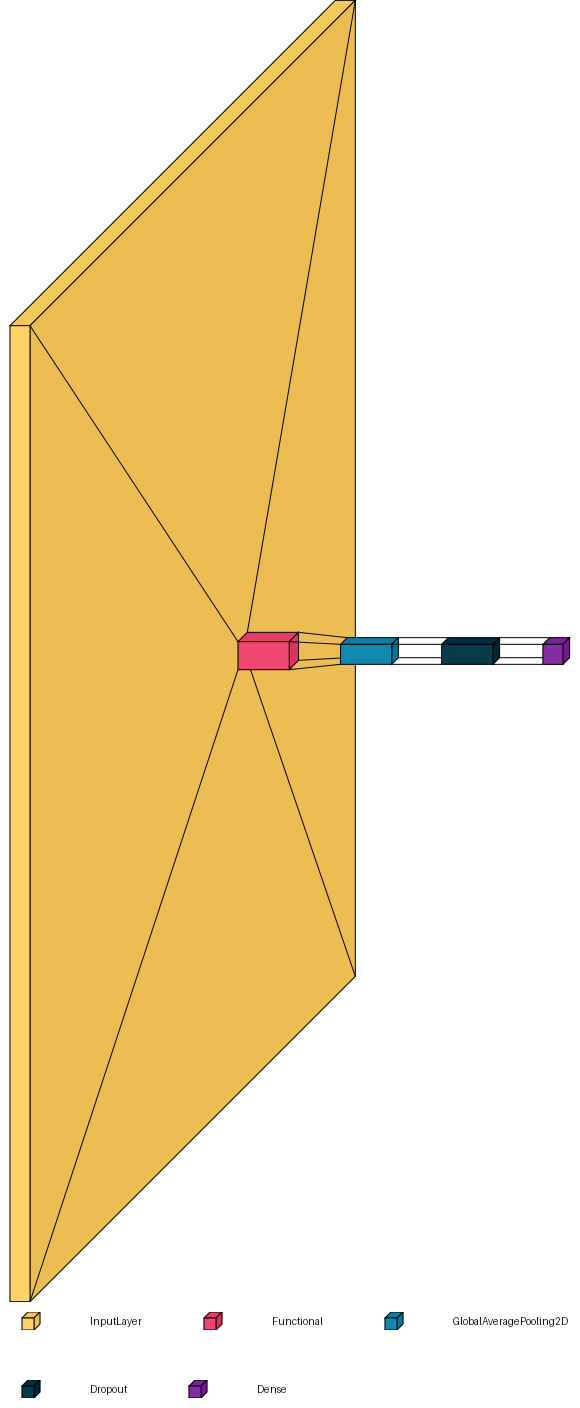

In [163]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model,legend=True,spacing=50,background_fill = 'white')

In [164]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [165]:
epoch = 40
model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 788ms/step - accuracy: 0.0786 - loss: 14.3345 - val_accuracy: 0.2703 - val_loss: 4.7440
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 367ms/step - accuracy: 0.2600 - loss: 5.6864 - val_accuracy: 0.4054 - val_loss: 3.2389
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.3898 - loss: 3.7932 - val_accuracy: 0.4757 - val_loss: 2.3848
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - accuracy: 0.5152 - loss: 2.7724 - val_accuracy: 0.5514 - val_loss: 1.9676
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.5055 - loss: 2.4617 - val_accuracy: 0.5676 - val_loss: 1.7495
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 501ms/step - accuracy: 0.5768 - loss: 1.9562 - val_accuracy: 0.6162 - val_loss: 1.5042
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 365ms/step - accuracy: 0.6365 - loss: 1.6593 - val_accuracy: 0.6162 - val_loss: 1.4205
Epoch 8/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 425ms/step - accuracy: 0.6504 - loss: 1.4338 - val_acc

In [166]:
#fine tuning
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_27         │ (None, 244, 244)  │          0 │ input_layer_21[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_28         │ (None, 244, 244)  │          0 │ input_layer_21[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_29         │ (None, 244, 244)  │          0 │ input_layer_21[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_9 (Stack)     │ (None, 244, 244,  │          0 │ get_item_27[0][0… │
│                     │ 3)                │            │ get_item_28[0][0… │
│                     │                   │            │ get_item_29[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 244, 244,  │          0 │ stack_9[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 90)        │     46,170 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,853,200 (56.66 MB)

 Trainable params: 7,125,594 (27.18 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 92,342 (360.71 KB)

In [167]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [168]:
epoch = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
        )
    ]
)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 475ms/step - accuracy: 0.7562 - loss: 0.7833 - val_accuracy: 0.8108 - val_loss: 0.7580
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 411ms/step - accuracy: 0.8923 - loss: 0.3014 - val_accuracy: 0.8270 - val_loss: 0.8153
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - accuracy: 0.9290 - loss: 0.2475 - val_accuracy: 0.8595 - val_loss: 0.8483
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - accuracy: 0.9773 - loss: 0.0878 - val_accuracy: 0.8541 - val_loss: 0.7162
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.9867 - loss: 0.0657 - val_accuracy: 0.8378 - val_loss: 0.7300
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.9809 - loss: 0.0744 - val_accuracy: 0.8216 - val_loss: 0.8767
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - accuracy: 0.9864 - loss: 0.0401 - val_accuracy: 0.8486 - val_loss: 0.8695
Epoch 7: early stopping


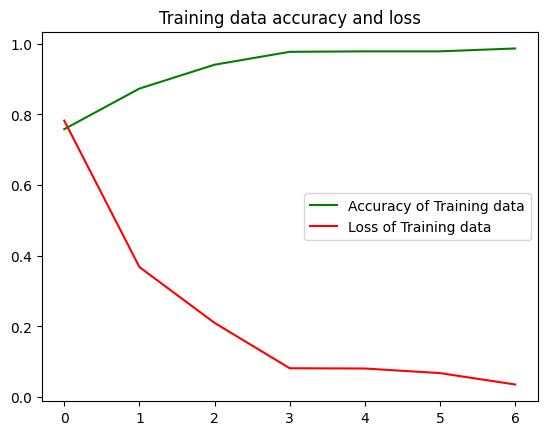

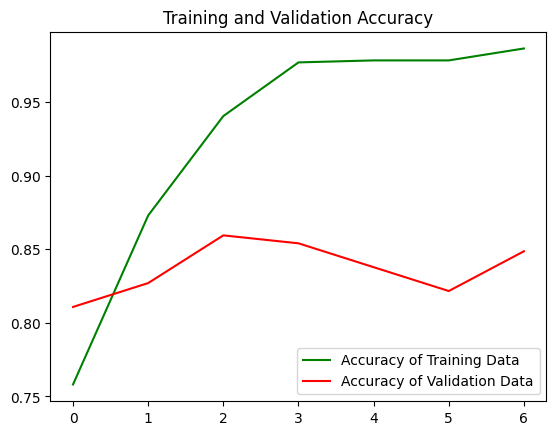

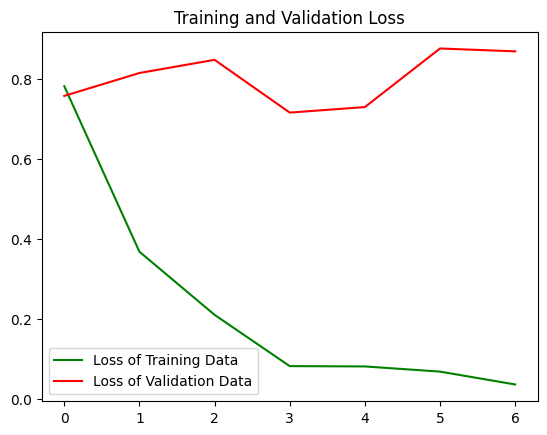

<Figure size 640x480 with 0 Axes>

In [169]:
get_ac = history.history['accuracy']
get_los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [170]:
oss, accuracy = model.evaluate(val_ds)

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})

        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

Output hidden; open in https://colab.research.google.com to view.

In [41]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])


In [42]:
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    # your model layers here...
])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


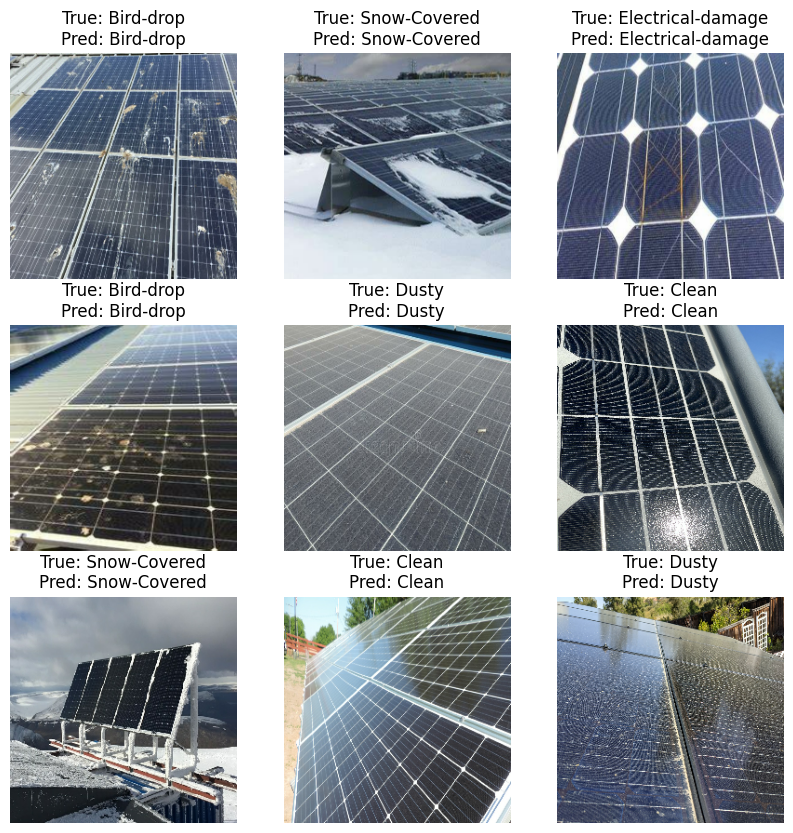

In [171]:
import matplotlib.pyplot as plt
import numpy as np

class_names = train_ds.class_names

for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis("off")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted class: Physical-Damage


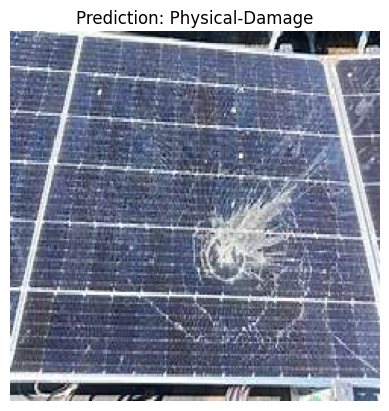

In [174]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Set the image size (must match what the model expects)
img_height = 244
img_width = 244

# Path to the image you want to test
img_path = '/content/th.jpeg'  # <-- change to your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # add batch dimension

# Predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Get class names (assuming you still have them)
class_names = train_ds.class_names
print("Predicted class:", class_names[predicted_class])

# Show the image with prediction
plt.imshow(img)
plt.title(f"Prediction: {class_names[predicted_class]}")
plt.axis("off")
plt.show()
